# Direct Fidelity Estimation

Using a method known as direct fidelity estimation (DFE), see [DFE1] and [DFE2], it is possible to estimate the fidelity between 
* a target pure state $\rho_\psi = |\psi\rangle\langle \psi|$ to its experimental realization $\sigma$,
* a target unitary $U$ to its experimental realization $U_e$.
 
This can be done with a small number (relative to state and process tomography) of simple experimental settings that is independent of the system size. Such methods are useful for the experimental study of larger quantum information processing units.

In this notebook we explore some state and process DFE using the forest.benchmarking module `direct_fidelity_estimation.py`.

## Simplistic example

Suppose we have tried to prepare the state $|0\rangle$ but in fact prepared the state

$$\sigma = \frac 1 2 (I + x X + y Y + z Z).$$


The usual way to quantify how close $\sigma$ and $|0\rangle$ are is to do quantum state tomography 
and estimate $\sigma$ and then calculate the fidelity be $\sigma$ and $|0\rangle$.


DFE provides a way to directly estimate the fidelity without first estimating the state $\sigma$. Although we can write the fidelity as $F(\rho_0, \sigma) = \langle 0 |\sigma|0 \rangle$ we use the expression

$$
F(\rho_0, \sigma) = {\rm Tr}[\rho_0  \sigma].
$$
Next we parameterize the pure state as

$$\rho_0= |0\rangle \langle 0| =  \frac 1 2 \big (I + (0) X + (0) Y + (+1) Z \big)=  \frac 1 2 (I +  Z ).$$

Finally we arrive at

$$
F(\rho_0, \sigma)= {\rm Tr}[\rho_0 \sigma] = \frac 1 4 {\rm Tr}[(1+z)I]= \frac{(1+z)}{2},
$$
this result shows that we only need to estimate one observable $\langle Z \rangle$ in order to estimate the fidelity between $\rho_0$ and $\sigma$ in this particular example.


## Addtional Details

**State DFE:** State fidelity between the experimental state $\sigma$ and the ideal (pure) state $\rho_\psi = |\psi\rangle\langle \psi|$ 
matrices is 

$$
F(\rho_\psi, \sigma) = {\rm Tr}[\rho_\psi  \sigma] = \langle \psi |\sigma|\psi \rangle.
$$

The direct fidelity estimate for a state is given by the average expected value of the Pauli operators in the
stabilizer group of the ideal pure state (see Eqn. 1 of [DFE1]).

**Process DFE:** The average gate fidelity between the experimental process $\mathcal E$ and the ideal (unitary) process $\mathcal U$ is defined as
$$
F(\mathcal U,\mathcal E) = \frac{ {\rm Tr} [\mathcal E \mathcal U^\dagger] + d} {d^2+d} 
$$
where the processes are represented by linear superoperators acting of vectorized
density matrices, and d is the dimension of the Hilbert space $\mathcal E$ and $\mathcal U$ act on. If you are unfamiliar with these terms look at [superoperator tools notebook](superoperator_tools.ipynb) and [superoperator_representations.md](../.././forest-benchmarking/docs/superoperator_representations.md)

The average gate fidelity can be re-written a 
$$
F(\mathcal U,\mathcal E)= \frac{d^2 {\rm Tr} J(\mathcal E)⋅J(\mathcal U) + d}{d^2+d}
$$
where $J()$ is the Choi-Jamiolkoski representation of the superoperator in the argument. Since the Choi-Jamiolkowski representation
is given by a density operator, the connection to the calculation of state fidelity becomes apparent:
$F(J(ℰ),J(𝒰)) = {\rm Tr} J(\mathcal E)⋅J(\mathcal U)$ is the state fidelity between Choi-Jamiolkoski states.

Noting that the Choi-Jamiolkoski state is prepared by acting on half of a maximally entangled state with the
process in question, the direct fidelity estimate of the Choi-Jamiolkoski state is given by the average expected
value of a Pauli operator resulting from applying the ideal unitary $\mathcal U$ to a Pauli operator $P_i$, for the state
resulting from applying the ideal unitary to a stabilizer state that has $P_i$ in its stabilizer group (one must be
careful to prepare states that have both +1 and -1 eigenstates of the operator in question, to emulate the random
state preparation corresponding to measuring half of a maximally entangled state).

[DFE1]  Practical Characterization of Quantum Devices without Tomography  
        Silva et al.,  
        PRL 107, 210404 (2011)  
        https://doi.org/10.1103/PhysRevLett.107.210404  
        https://arxiv.org/abs/1104.3835  

[DFE2]  Direct Fidelity Estimation from Few Pauli Measurements  
        Flammia et al.,  
        PRL 106, 230501 (2011)  
        https://doi.org/10.1103/PhysRevLett.106.230501  
        https://arxiv.org/abs/1104.4695  

In [1]:
from pyquil.paulis import ID
from pyquil.gates import I, X, MEASURE, H, CNOT, RY, CZ
from pyquil import Program, get_qc
from pyquil.api import get_benchmarker
from forest.benchmarking.direct_fidelity_estimation import ( generate_exhaustive_state_dfe_experiment, 
                                                             generate_exhaustive_process_dfe_experiment,
                                                             generate_monte_carlo_state_dfe_experiment, 
                                                             generate_monte_carlo_process_dfe_experiment,
                                                             acquire_dfe_data,
                                                             estimate_dfe )
from pyquil.operator_estimation import measure_observables

import numpy as np
from matplotlib import pyplot

In [2]:
# noiseless QVM
qvm = get_qc("9q-generic-qvm", as_qvm=True, noisy=False)

# noisy QVM
noisy_qvm = get_qc("9q-generic-qvm", as_qvm=True, noisy=True)

bm = get_benchmarker()

## Direct fidelity estimation in `forest.benchmarking`

The basic workflow is:

1. Prepare a *state* or a *process* by specifying a pyQuil program.
2. Construct a list of observables that are needed to estimate the state; we collect this into an object called an `ObservablesExperiment`.
3. Acquire the data by running the program on a QVM or QPU.
4. Apply an estimator to the data to obtain an estimate of the fidelity between the ideal and measured state or process.
5. Visualize if you wish.

## Two quick examples

### Step 1. Prepare a state or unitarty with a `Program`

This is the object we will do DFE on.

The process we choose is 
$$
U = {\rm CNOT}(H\otimes I)=\frac{1}{\sqrt{2}}
\begin{pmatrix}
1 & 0 & 1 & 0\\
0 & 1 & 0 & 1\\
0 & 1 & 0 & -1\\
1 & 0 & -1 & 0
\end{pmatrix}
$$
and the state is
$$
|\Psi\rangle = {\rm CNOT}(H\otimes I)|00\rangle = \frac{1}{\sqrt{2}} \begin{pmatrix} 1\\0\\0\\ 1\end{pmatrix}.
$$

In [3]:
p = Program()
prep_prog = p.inst(H(0), CNOT(0,1))
print(prep_prog)

H 0
CNOT 0 1



In [4]:
from pyquil.gate_matrices import I as Imatrix, H as Hmatrix, CNOT as CNOTmatrix

U_ideal = CNOTmatrix @ np.kron(Hmatrix, Imatrix)
print(U_ideal)

rho_ideal = U_ideal @ np.array([[1], [0], [0], [0]]) @ np.array([[1], [0], [0], [0]]).T @ U_ideal.conj().T
print(rho_ideal)

[[ 0.70710678  0.          0.70710678  0.        ]
 [ 0.          0.70710678  0.          0.70710678]
 [ 0.          0.70710678  0.         -0.70710678]
 [ 0.70710678  0.         -0.70710678  0.        ]]
[[0.5 0.  0.  0.5]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.5 0.  0.  0.5]]


### Step 2. Construct a `ObservablesExperiment` for DFE

We use the helper functions  
* `generate_exhaustive_state_dfe_experiment` 
* `generate_exhaustive_process_dfe_experiment`

to construct a tomographically incomplete set of measurements.

We can print this out to see the 15 observables or operator measurements we will perform. Note that we could have included an additional observable `I0I1`, but since this trivially gives an expectation of 1 we instead omit this observable in experiment generation and include its contribution by hand in the estimation methods. Be mindful of this if generating your own settings.

In [5]:
qubits = [0,1]

# state dfe
state_exp = generate_exhaustive_state_dfe_experiment(prep_prog, qubits, bm)

# process dfe
process_exp = generate_exhaustive_process_dfe_experiment(prep_prog, qubits, bm)

In [6]:
# Lets take a look into one of these experiment objects

print('The type of the object is:', type(state_exp),'\n')
print('The program is:')
print(state_exp.program)
print('There are three experiments:')
print(state_exp.settings_string())

The type of the object is: <class 'forest.benchmarking.observable_estimation.ObservablesExperiment'> 

The program is:
H 0
CNOT 0 1

There are three experiments:
0: Z0_0 * Z0_1→(1+0j)*Z0Z1
1: Z0_0 * Z0_1→(1+0j)*X0X1
2: Z0_0 * Z0_1→(-1+0j)*Y0Y1


### Step 3. Acquire the data

PyQuil will run the tomography programs. We will use the QVM but at this point you can use a QPU.

Note that `acquire_dfe_data` returns a `list` of `ExperimentResult`s which is a dataclass defined in the module `observable_estimation.py`.

The details of the dataclass and error mitigation strategies are in detail in the [observable estimation ipython notebook](observable_estimation.ipynb).

In [7]:
# get some NOISELESS data
results = acquire_dfe_data(qvm, process_exp, num_shots=1000)

In [8]:
# look at it
print("Operator Expectations")
print([res.expectation for res in results])
print('\n')
print("Calibration Expectations")
print([res.calibration_expectation for res in results])

Operator Expectations
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Calibration Expectations
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [9]:
# get some NOISY data
n_results_proce = acquire_dfe_data(noisy_qvm, process_exp, num_shots=1000)

n_results_state = acquire_dfe_data(noisy_qvm, state_exp, num_shots=1000)

In [10]:
# look at it
print("Noisy Operator Expectations")
print([np.round(res.expectation, 4) for res in n_results_proce])
print('\n')
print("Noisy Calibration Expectations")
print([res.calibration_expectation for res in n_results_proce])

Noisy Operator Expectations
[1.0221, 1.0116, 1.0, 0.9775, 0.9565, 0.9653, 0.9867, 1.0013, 0.964, 0.9807, 0.9761, 0.982, 0.9775, 0.9434, 0.9949, 0.9461, 0.9909, 0.9682, 0.9651, 0.9651, 0.998, 0.9783, 0.9966, 0.991, 0.9738, 1.0285, 0.9887, 0.983, 0.968, 1.0, 0.9552, 0.9411, 1.0126, 1.0, 1.0033, 0.9792, 0.9792, 0.9647, 0.9597, 0.9792, 0.9707, 1.0132, 0.9642, 0.9781, 0.9445, 0.9212, 0.9811, 0.9726]


Noisy Calibration Expectations
[0.859, 0.859, 0.7795, 0.7795, 0.793, 0.793, 0.901, 0.7785, 0.7785, 0.88, 0.88, 0.888, 0.888, 0.901, 0.7785, 0.7785, 0.88, 0.88, 0.888, 0.888, 0.7625, 0.876, 0.876, 0.7815, 0.7815, 0.7545, 0.7545, 0.7625, 0.876, 0.876, 0.7815, 0.7815, 0.7545, 0.7545, 0.757, 0.867, 0.867, 0.7935, 0.7935, 0.7675, 0.7675, 0.757, 0.867, 0.867, 0.7935, 0.7935, 0.7675, 0.7675]


### Step 4. Apply some estimators to the data "do DFE"

**Process DFE**

In [11]:
# estimate using NOISELESS data
fid_est, fid_std_err = estimate_dfe(results, 'process')

print('Fidelity point estimate is: ',fid_est)
print('The standard error of the fidelity point estimate is: ', fid_std_err)

Fidelity point estimate is:  1.0
The standard error of the fidelity point estimate is:  0.0


In [12]:
# estimate using NOISY data
nfid_est, nfid_std_err = estimate_dfe(n_results_proce, 'process')

print('Fidelity point estimate is', np.round(nfid_est, 4))
print('The std error of the fidelity point estimate is', np.round(nfid_std_err, 4))

Fidelity point estimate is 0.9844
The std error of the fidelity point estimate is 0.002


**State DFE**

In [13]:
# estimate using NOISY data
nfid_est_state, nfid_std_err_state = estimate_dfe(n_results_state, 'state')

print('Fidelity point estimate is', np.round(nfid_est_state, 4))
print('The std error of the fidelity point estimate is', np.round(nfid_std_err_state, 4))

Fidelity point estimate is 1.0015
The std error of the fidelity point estimate is 0.0079


### Step 5. Visualize


**State DFE**

We will start with state DFE as it is the simplest case.

In [14]:
from forest.benchmarking.tomography import iterative_mle_state_estimate

In [15]:
# use state tomography to estimate the state from incomplete information
rho_est = iterative_mle_state_estimate(n_results_state, qubits=[0,1])

np.round(rho_est, 3)

array([[ 0.465+0.j,  0.   +0.j,  0.   +0.j,  0.541+0.j],
       [ 0.   +0.j,  0.035+0.j, -0.035+0.j,  0.   +0.j],
       [ 0.   +0.j, -0.035+0.j,  0.035+0.j,  0.   +0.j],
       [ 0.541+0.j,  0.   +0.j,  0.   +0.j,  0.465+0.j]])

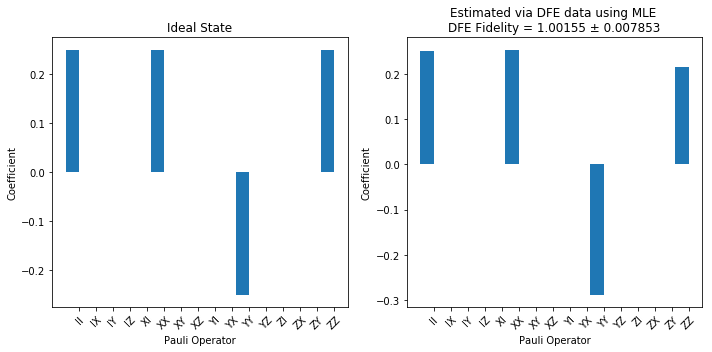

In [16]:
import matplotlib.pyplot as plt
from forest.benchmarking.utils import n_qubit_pauli_basis
from forest.benchmarking.operator_tools.superoperator_transformations import vec, computational2pauli_basis_matrix
from forest.benchmarking.plotting.state_process import plot_pauli_rep_of_state, plot_pauli_bar_rep_of_state

# convert to pauli representation
n_qubits = 2
pl_basis = n_qubit_pauli_basis(n_qubits)
c2p = computational2pauli_basis_matrix(2*n_qubits)

rho_true_pauli = np.real(c2p @ vec(rho_ideal))
rho_mle_pauli = np.real(c2p @ vec(rho_est)) 

fig1, (ax3, ax4) = plt.subplots(1, 2, figsize=(10,5))
title_res = f"Estimated via DFE data using MLE \n" f"DFE Fidelity = {np.round(nfid_est_state, 5)} ± {np.round(nfid_std_err_state, 6)}"
plot_pauli_bar_rep_of_state(rho_true_pauli.flatten(), ax=ax3, labels=pl_basis.labels, title='Ideal State')
plot_pauli_bar_rep_of_state(rho_mle_pauli.flatten(), ax=ax4, labels=pl_basis.labels, title=title_res)
fig1.tight_layout()

**Process DFE**

We will start with state DFE as it is the simplest case.

In [17]:
from forest.benchmarking.tomography import pgdb_process_estimate

choi_mle_est = pgdb_process_estimate(n_results_proce, qubits)

# sneak peak at part of the estimated process
np.real_if_close(np.round(choi_mle_est, 2))[0:4]

array([[ 0.5 , -0.  ,  0.  ,  0.5 , -0.  ,  0.49,  0.49, -0.  ,  0.49,
         0.  , -0.  , -0.49,  0.  ,  0.39, -0.39, -0.  ],
       [-0.  ,  0.  , -0.  , -0.  ,  0.01,  0.  , -0.  , -0.01, -0.  ,
         0.01,  0.01, -0.  ,  0.03, -0.  ,  0.  ,  0.03],
       [ 0.  , -0.  ,  0.  ,  0.  , -0.01, -0.  ,  0.  ,  0.01,  0.  ,
        -0.01, -0.01,  0.  , -0.03,  0.  , -0.  , -0.03],
       [ 0.5 , -0.  ,  0.  ,  0.5 , -0.  ,  0.49,  0.49, -0.  ,  0.49,
         0.  , -0.  , -0.49,  0.  ,  0.39, -0.39, -0.  ]])

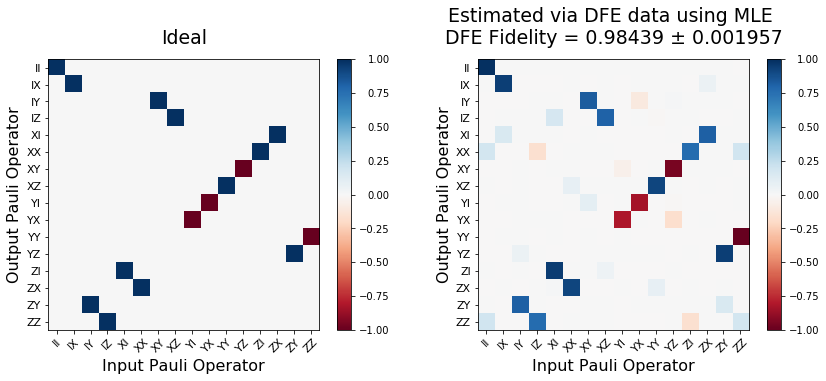

In [18]:
from forest.benchmarking.plotting.state_process import plot_pauli_transfer_matrix
from forest.benchmarking.operator_tools import choi2pauli_liouville, kraus2pauli_liouville


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
title_res = f"Estimated via DFE data using MLE \n" f"DFE Fidelity = {np.round(nfid_est, 5)} ± {np.round(nfid_std_err, 6)}"
plot_pauli_transfer_matrix(np.real(kraus2pauli_liouville(U_ideal)), ax1, title='Ideal')
plot_pauli_transfer_matrix(np.real(choi2pauli_liouville(choi_mle_est)), ax2, title=title_res)
plt.tight_layout()

## State fidelity between $\left|0\right\rangle$ and $|\theta\rangle = R_y(\theta)\left|0\right\rangle$


In this section we check that state DFE is working correctly by comparing with an analytical calcuation. 
Essentially we would like to prepare $|0\rangle$ but for some reason we actually prepare $|\theta\rangle = R_y(\theta)|0\rangle$. The fidelity in that case is
$$
\begin{align}
F\big(|0\rangle, |\theta\rangle \big) &= |\langle 0|R_y(\theta) |0\rangle |^2\\
&= \cos^2(\theta/2)\\
&= \frac{1}{2} \big (1 +\cos(\theta) \big). 
\end{align}
$$

So the point of this section is to try and "experimentally" plot the fidelity expression as a function of $\theta$.

**Note:** in some of the cells below there is a comment `# NBVAL_SKIP` this is used in testing to speed up our tests by skipping that particular cell.

In [19]:
# start by constructing the identity program
qubits = [0]
prog = Program(I(0))

# design state DFE experiment to estimate |0>
zero_state_experiment = generate_exhaustive_state_dfe_experiment(prog, qubits, bm)

In [20]:
# get data and estimate
zero_state_data = acquire_dfe_data(qvm, zero_state_experiment, num_shots=1000)

zero_fid_est, zero_fid_std_err = estimate_dfe(zero_state_data, 'state')
print('The estimated fidelity is:', zero_fid_est)

The estimated fidelity is: 1.0


So obviously we need to do something different.

We need to modify the program that is run to be `RY(theta,0)` instead of identity. 
What that means is technically we will be doing the "wrong" expermient, recall we `generate_exhaustive...state_dfe_exp` under the assumption that our program was identity. But that is entirely the point, in this case the unitary rotation is an error.


In [21]:
# NBVAL_SKIP
points = 10
res = []
res_std_err = []

# loop over different angles
for theta in np.linspace(0, np.pi, points):
    # modify the experiment object to do the "wrong" program
    zero_state_experiment.program = Program(RY(theta,0))
    ry_state_data = acquire_dfe_data(qvm, zero_state_experiment, num_shots=1000)
    fid_est, fid_std_err = estimate_dfe(ry_state_data, 'state')
    res.append(fid_est)
    res_std_err.append(2*fid_std_err)

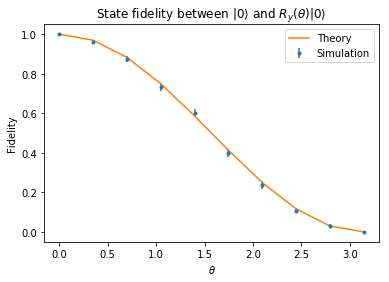

In [22]:
# NBVAL_SKIP
pyplot.errorbar(np.linspace(0, np.pi, points), res, res_std_err, fmt=".", label="Simulation")
pyplot.plot(np.linspace(0, np.pi, points), (1/2+1/2*np.cos(np.linspace(0, np.pi, points))), label="Theory")
pyplot.xlabel(r"$\theta$")
pyplot.ylabel("Fidelity")
pyplot.legend()
pyplot.title(r"State fidelity between $\left|0\right\rangle$ and $R_y(\theta)\left|0\right\rangle$")
pyplot.show()

## Process fidelity between $I$ and $R_y(\theta)$

Like the state fidelity example above we will construct a DFE experiment to estimate the identity but include a unitary error, in this case $R_y(\theta)$. Then we will show that process DFE is consistent with the analytical calcuation.

The process fidelity is easy to calculate using Enq 5 from [arXiv:quant-ph/0701138](https://arxiv.org/pdf/quant-ph/0701138.pdf). The fidelity between the unitary $U_0$ the quantum operation specified by the Kraus operators $\{ G_k \}$ is 
$$
F(\{ G_k \}, U_0) 
= \frac{1}{d(d+1)} \big ( {\rm Tr}\big [\sum_k M_k^\dagger M_k \big ] + \sum_k |{\rm Tr}[ M_k]|^2 \big ),
$$
where $M_k = U_0^\dagger G_k$.

In the context we care about we have a single Kraus operator so $\{ G_k \} = R_y(\theta)$ and $U_0=I$. So the fidelity becomes
$$
F\big(R_y(\theta), I \big) 
= \frac{1}{3} \big (1 +2\cos^2(\theta/2) \big ),
$$
where we used $R_y(\theta) = \exp[-i \theta Y /2]= \cos(\theta/2) I - i \sin(\theta/2)Y$.

In [23]:
# start by constructing the identity program
prog = Program(I(0))
qubits = [0]

# design process DFE experiment to estimate I
id_proc_exp = generate_exhaustive_process_dfe_experiment(prog, qubits, bm)

Now modify the program that is run to be `RY(theta,0)` instead of identity. As above that means is technically we will be doing the "wrong" expermient.

In [24]:
# NBVAL_SKIP
points = 10
res = []
res_std_err = []
for theta in np.linspace(0, np.pi, points): 
    # modify the experiment object to do the "wrong" program
    id_proc_exp.program = Program(RY(theta,0))
    ry_proc_data = acquire_dfe_data(qvm, id_proc_exp, num_shots=500)
    fid_est, fid_std_err = estimate_dfe(ry_proc_data, 'process')
    res.append(fid_est)
    res_std_err.append(2*fid_std_err)

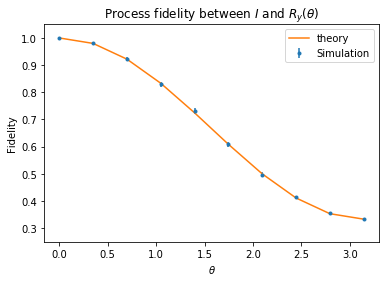

In [25]:
# NBVAL_SKIP
pyplot.errorbar(np.linspace(0, np.pi, points), res, res_std_err, fmt=".", label="Simulation")
pyplot.plot(np.linspace(0, np.pi, points), 
            (1 + 2*np.cos(np.linspace(0, np.pi, points)/2)**2)/3,
            label="theory")
pyplot.xlabel(r"$\theta$")
pyplot.ylabel("Fidelity")
pyplot.legend()
pyplot.ylim(0.25,1.05)
pyplot.title(r"Process fidelity between $I$ and $R_y(\theta)$")
pyplot.show()

## Advanced 

### Monte Carlo Sampling of large graph states

We can do [Monte Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_method) or random sampling of operators in large states or processes.

* `generate_monte_carlo_state_dfe_experiment`
* `generate_monte_carlo_process_dfe_experiment`

generally you need to specify a number of terms

In [9]:
import networkx as nx
from matplotlib import pyplot as plt
from forest.benchmarking.entangled_states import create_graph_state

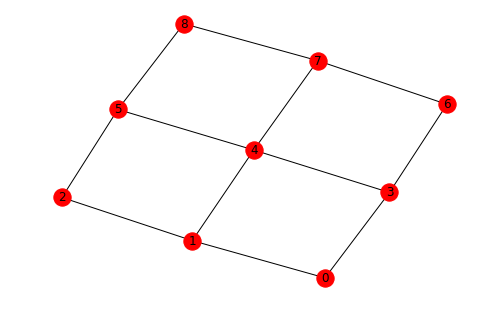

In [28]:
nx.draw(noisy_qvm.qubit_topology(), with_labels=True)

# we will do a subgraph
graph = nx.from_edgelist([(0, 1), (0, 3), (1, 2), (1, 4), (3, 4)])

In [29]:
graph_prep_prog = create_graph_state(graph)

qubits = list(graph_prep_prog.get_qubits())
print(graph_prep_prog)
qubits

H 0
H 1
H 3
H 2
H 4
CZ 0 1
CZ 0 3
CZ 1 2
CZ 1 4
CZ 3 4



[0, 1, 2, 3, 4]

In [32]:
gstate_exp_exh = generate_exhaustive_state_dfe_experiment(graph_prep_prog, qubits, bm)
gstate_exp_mc = generate_monte_carlo_state_dfe_experiment(graph_prep_prog, qubits, bm, n_terms=8)

In [33]:
num_exh_exp = len(list(gstate_exp_exh.setting_strings()))
num_mc_exp = len(list(gstate_exp_mc.setting_strings()))

print(f'In exhaustive state DFE there is {num_exh_exp} experiments.\n' )

print(f'In monte carlo state DFE we chose {num_mc_exp} experiments.' )

In exhaustive state DFE there is 31 experiments.

In monte carlo state DFE we chose 8 experiments.


In [34]:
# NBVAL_SKIP
%%time
graph_state_mc_data = acquire_dfe_data(noisy_qvm, gstate_exp_mc, num_shots=500)

fid_est, fid_std_err = estimate_dfe(graph_state_mc_data, 'state')
print(f'The four qubit graph fidelity estimate is {fid_est}.\n')
print('Monte-Carlo took this long:\n')

The four qubit graph fidelity estimate is 0.954389294048847.

Monte-Carlo took this long:

CPU times: user 15.7 s, sys: 88.6 ms, total: 15.8 s
Wall time: 52.2 s


In [35]:
# NBVAL_SKIP
%%time
graph_state_exh_data = acquire_dfe_data(noisy_qvm, gstate_exp_exh, num_shots=500)

fid_est, fid_std_err = estimate_dfe(graph_state_exh_data, 'state')
print(f'The four qubit graph fidelity estimate is {fid_est}.\n')
print('Exhaustive took this long:\n')

The four qubit graph fidelity estimate is 0.9506687660612446.

Exhaustive took this long:

CPU times: user 56.8 s, sys: 279 ms, total: 57.1 s
Wall time: 3min 8s


### DFE measurements that include spectator qubits that signify cross talk.

Suppose you wanted to do process tomography on a CZ gate.

It turns out in many superconducting qubits there are many kinds of cross talk at play.


So one way to measure that is to do the gate you care about and then "install" identites on spectator qubits.
If the process is not Identity on those qubits DFE will pick it up.

Of course, such expereiments are best done on the QPU or at the least with a noise model.

In [55]:
prog = Program(CZ(0,1), I(2))
qubits = prog.get_qubits()

The CZ gate is: CZ(0,1)


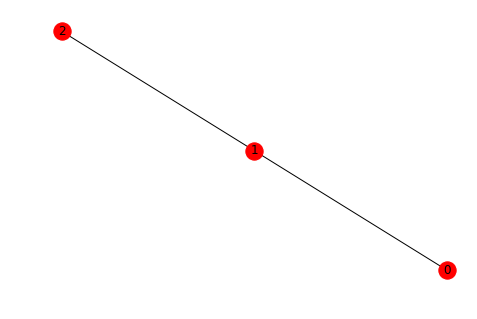

In [56]:
print('The CZ gate is: CZ(0,1)')
nx.draw(nx.from_edgelist([(0, 1), (1, 2)]), with_labels=True)

In [64]:
xtalk_proc_exp = generate_monte_carlo_process_dfe_experiment(prog, qubits, bm, n_terms=20)

TypeError: 'set' object is not subscriptable

In [61]:
len(list(xtalk_proc_exp.setting_strings()))

342

In [65]:
xtalk_data = acquire_dfe_data(qvm, xtalk_proc_exp, num_shots=500)

In [ ]:
fid_est, fid_std_err = estimate_dfe(xtalk_data, 'process')
fid_est

If we wanted to we could "amplify" the cross talk error by applying the gate many times

In [ ]:
prog = Program(CZ(0,1), CZ(0,1), CZ(0,1), I(2))

### Parallel state and process DFE

In [ ]:
# TODO